<center><h1>Методы Монте-Карло и машинное обучение</h1></center>

In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

### Импорт необходимых библиотек
import os
import torch
import polars as pl
import seaborn as sns
import yfinance
import sklearn
import numpy as np
import datasets
import matplotlib as mpl
import matplotlib.pyplot as plt
import jupyterlab as jlab
import ipywidgets
import pandas as pd

from datasets import load_dataset
pd.set_option('display.max_columns', None) 

In [3]:
squad_dataset = load_dataset('phihung/titanic')

In [4]:
data = pd.DataFrame(squad_dataset["train"])

In [5]:
data = pd.concat([data,
                   pd.get_dummies(data["Cabin"].str.replace(r"[^A-Z]","", regex=True).str[0], prefix='Cabin').astype(int),
                   pd.get_dummies(data["Embarked"], prefix= "Embarked").astype(int)], axis = 1).drop(columns=["Embarked_S","Name","Ticket","Cabin","Embarked"])

data["Sex"] = data["Sex"].map({"male":1, "female":0})

In [6]:
data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q
0,1,0,3,1,22.0,1,0,7.2500,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,1,0
2,3,1,3,0,26.0,0,0,7.9250,0,0,0,0,0,0,0,0,0,0
3,4,1,1,0,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0,0
4,5,0,3,1,35.0,0,0,8.0500,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,13.0000,0,0,0,0,0,0,0,0,0,0
887,888,1,1,0,19.0,0,0,30.0000,0,1,0,0,0,0,0,0,0,0
888,889,0,3,0,NaN,1,2,23.4500,0,0,0,0,0,0,0,0,0,0
889,890,1,1,1,26.0,0,0,30.0000,0,0,1,0,0,0,0,0,1,0


In [8]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# XGBOOST

In [9]:
SEED = 42 

# Без Монте-Карло (одно разбиение)
X_train, X_test, y_train, y_test = train_test_split(data[[i for i in data.columns if i not in  ["Survived", "PassengerId"]]], data["Survived"], test_size=0.2, random_state=SEED)

model = XGBClassifier(objective='binary:logistic', 
                         eval_metric='logloss',
                         use_label_encoder=False,
                         random_state=42)

# Предсказание
model.fit(X_train,y_train)
predictions = model.predict(X_test)

accuracy_no_mc = accuracy_score(predictions, y_test)
print(accuracy_no_mc)

0.7821229050279329


In [10]:
# С Монте-Карло (несколько разбиений)
n_simulations = 200
accuracies_mc = []

for i in tqdm(range(n_simulations)):
    X_train, X_test, y_train, y_test = train_test_split(data[[i for i in data.columns if i not in  ["Survived", "PassengerId"]]], data["Survived"], test_size=0.2)

    model_mc = XGBClassifier(objective='binary:logistic', 
                         eval_metric='logloss',
                         use_label_encoder=False)
    # Предсказание
    model_mc.fit(X_train, y_train)
    predictions = model_mc.predict(X_test)
    acc = accuracy_score(predictions, y_test)
    accuracies_mc.append(acc)

mean_accuracy_mc = np.mean(accuracies_mc)
std_accuracy_mc = np.std(accuracies_mc)

print("Средняя точность", mean_accuracy_mc)
print("Отклонение точности", std_accuracy_mc)

100%|██████████| 200/200 [00:10<00:00, 18.40it/s]


Средняя точность 0.8101117318435754
Отклонение точности 0.02599410784236536


In [11]:
# Оптимизация гиперпараметров с помощью Монте-Карло
# Гиперпараметры для поиска
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# Создаем модель XGBoost
xgb_model = XGBClassifier(objective='binary:logistic', 
                         eval_metric='logloss',
                         use_label_encoder=False,
                         random_state=42)

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model,
                          param_grid=param_grid,
                          cv=5,
                          scoring='accuracy',
                          n_jobs=-1,
                          verbose=1)

# Запуск поиска
grid_search.fit(X_train, y_train)

# Результаты
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность на кросс-валидации и тестовой выборке:", grid_search.best_score_)

# Лучшая модель
best_xgb = grid_search.best_estimator_

# возвращаем начальное разбиение и тестим на нем
X_train, X_test, y_train, y_test = train_test_split(data[[i for i in data.columns if i not in  ["Survived", "PassengerId"]]], data["Survived"], test_size=0.2, random_state=SEED)

grid_predictions = best_xgb.predict(X_test)
print("Точность лучшей модели на тест данных: ", accuracy_score(grid_predictions,y_test))

NameError: name 'GridSearchCV' is not defined

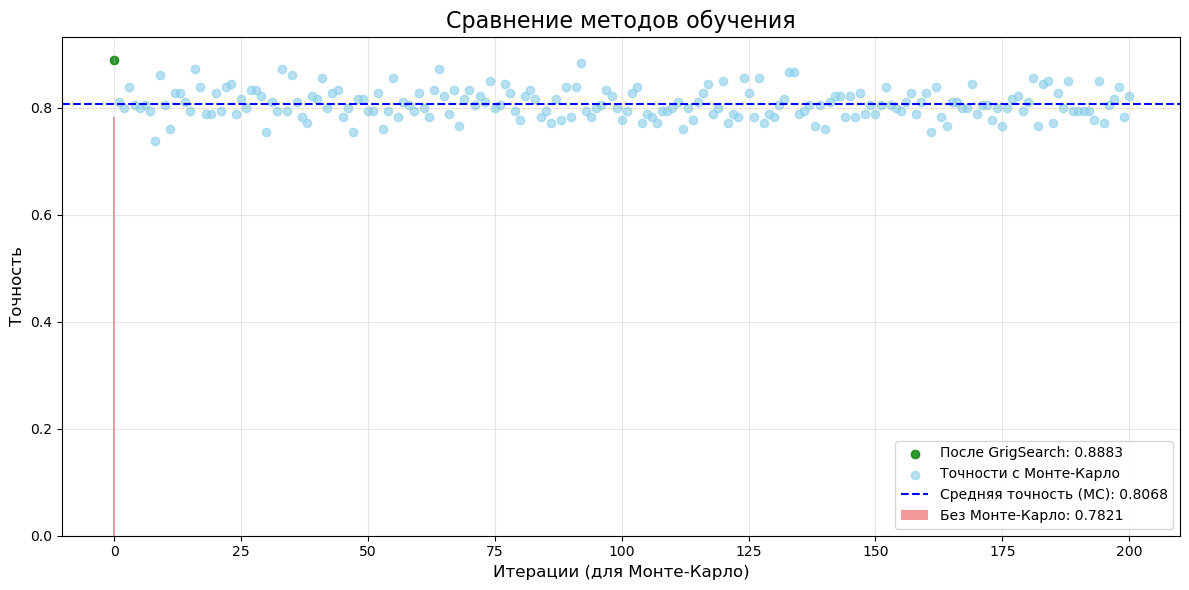

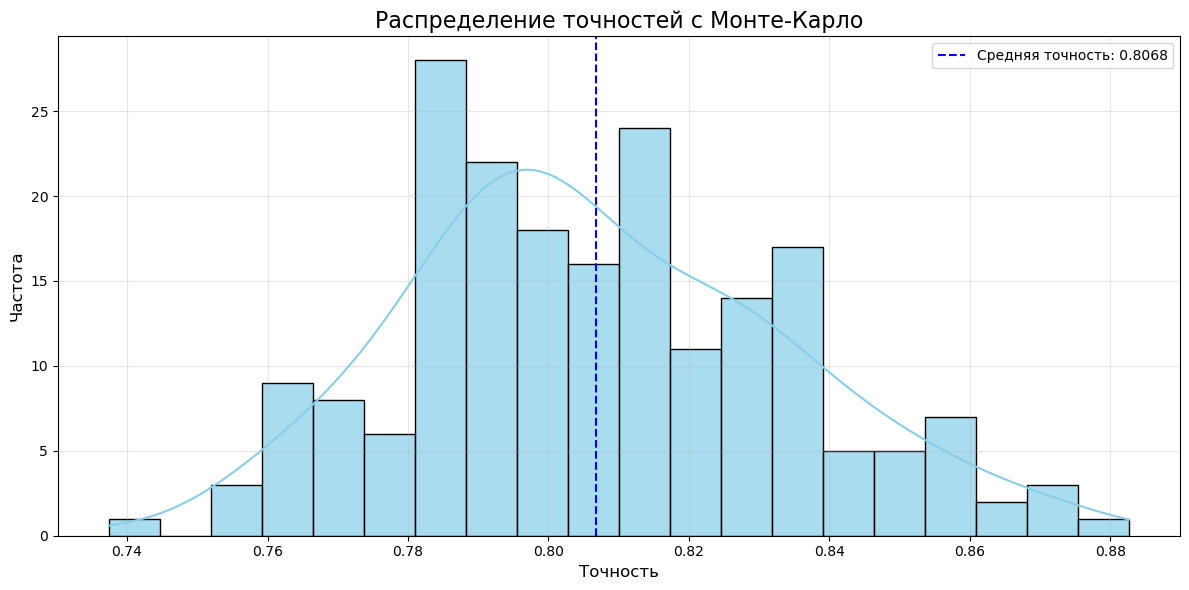

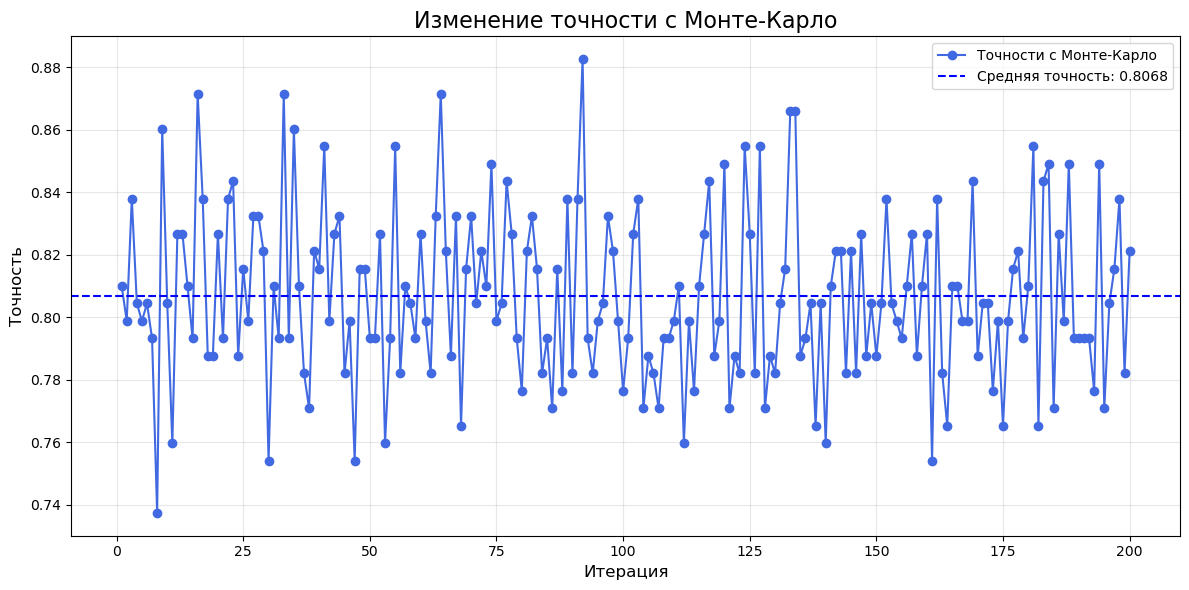

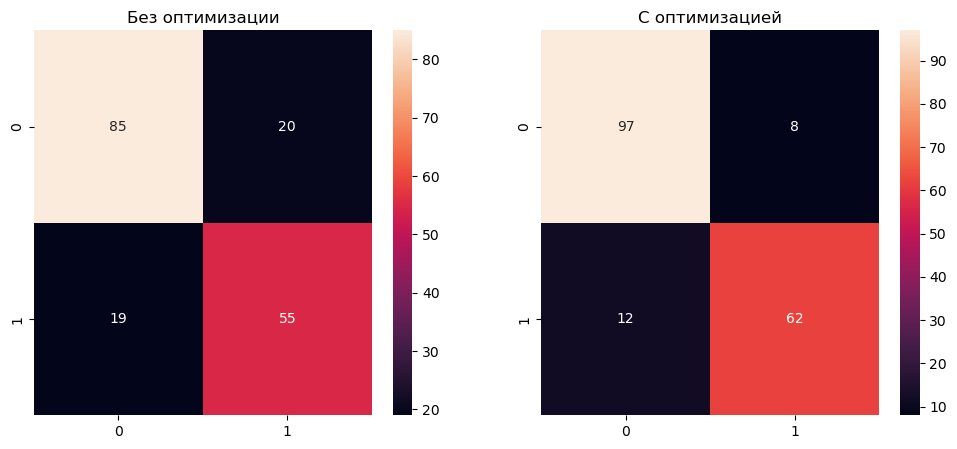

In [ ]:
# Визуализация

# График 1: Сравнение точности с и без Монте-Карло
plt.figure(figsize = (12, 6))
plt.bar(
    [0], 
    [accuracy_no_mc], 
    color = "lightcoral", 
    alpha = 0.8, 
    width = 0.4, 
    label = f"Без Монте-Карло: {accuracy_no_mc:.4f}"
)
plt.scatter(
    [0], 
    [accuracy_score(grid_predictions,y_test)], 
    color = "green", 
    alpha = 0.8,  
    label = f"После GrigSearch: {accuracy_score(grid_predictions,y_test):.4f}"
)
plt.scatter(
    range(1, n_simulations + 1), 
    accuracies_mc, 
    color = "skyblue", 
    label = "Точности с Монте-Карло", 
    alpha = 0.6
)
plt.axhline(mean_accuracy_mc, color = "blue", linestyle = "--", linewidth = 1.5, label = f"Средняя точность (MC): {mean_accuracy_mc:.4f}")
plt.title("Сравнение методов обучения", fontsize = 16)
plt.xlabel("Итерации (для Монте-Карло)", fontsize = 12)
plt.ylabel("Точность", fontsize = 12)
plt.legend(fontsize = 10)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

# График 2: Плотность распределения точностей (с Монте-Карло)
plt.figure(figsize = (12, 6))
sns.histplot(accuracies_mc, kde = True, bins = 20, color = "skyblue", alpha = 0.7)
plt.axvline(mean_accuracy_mc, color = "blue", linestyle = "--", label = f"Средняя точность: {mean_accuracy_mc:.4f}")
plt.title("Распределение точностей с Монте-Карло", fontsize = 16)
plt.xlabel("Точность", fontsize = 12)
plt.ylabel("Частота", fontsize = 12)
plt.legend(fontsize = 10)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

# График 3: Точности по итерациям
plt.figure(figsize = (12, 6))
plt.plot(range(1, n_simulations + 1), accuracies_mc, marker = "o", color = "royalblue", label = "Точности с Монте-Карло")
plt.axhline(mean_accuracy_mc, color = "blue", linestyle = "--", linewidth = 1.5, label = f"Средняя точность: {mean_accuracy_mc:.4f}")
plt.title("Изменение точности с Монте-Карло", fontsize = 16)
plt.xlabel("Итерация", fontsize = 12)
plt.ylabel("Точность", fontsize = 12)
plt.legend(fontsize = 10)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()


cm_no_mc = confusion_matrix(y_test, model.predict(X_test))
cm_grad = confusion_matrix(y_test, best_xgb.predict(X_test))

# Визуализация
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_no_mc, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Без оптимизации')
sns.heatmap(cm_grad, annot=True, fmt='d', ax=ax[1])
ax[1].set_title('С оптимизацией')
plt.show()

# CATBOOST

In [ ]:
data = pd.DataFrame(squad_dataset["train"])

In [ ]:
data["Cabin"] = data["Cabin"].astype(str)
data["Embarked"] = data["Embarked"].astype(str)
data["Age"] = data["Age"].fillna(-1)

In [ ]:
SEED = 42 

# Без Монте-Карло (одно разбиение)
X_train, X_test, y_train, y_test = train_test_split(data[[i for i in data.columns if i not in  ["Survived", "PassengerId","Name","Ticket"]]],
                                                     data["Survived"], test_size=0.2, random_state=SEED)

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=["Sex", "Cabin", "Embarked"],
    verbose=100,
    random_state=SEED
)

# Предсказание
model.fit(X_train,y_train)
predictions = model.predict(X_test)

accuracy_no_mc = accuracy_score(predictions, y_test)
print(accuracy_no_mc)

0:	learn: 0.6585611	total: 24.3ms	remaining: 2.41s
99:	learn: 0.3602248	total: 2.06s	remaining: 0us
0.7877094972067039


In [ ]:
# С Монте-Карло (несколько разбиений)
n_simulations = 100
accuracies_mc = []

for i in tqdm(range(n_simulations)):
    X_train, X_test, y_train, y_test = train_test_split(data[[i for i in data.columns if i not in  ["Survived", "PassengerId","Name","Ticket"]]],
                                                     data["Survived"], test_size=0.2)

    model_mc = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        cat_features=["Sex", "Cabin", "Embarked"],
        verbose=False,
)
    # Предсказание
    model_mc.fit(X_train, y_train)
    predictions = model_mc.predict(X_test)
    acc = accuracy_score(predictions, y_test)
    accuracies_mc.append(acc)

mean_accuracy_mc = np.mean(accuracies_mc)
std_accuracy_mc = np.std(accuracies_mc)

print("Средняя точность", mean_accuracy_mc)
print("Отклонение точности", std_accuracy_mc)

100%|██████████| 100/100 [03:30<00:00,  2.11s/it]


0.8095530726256984 0.026037295623718256


In [ ]:
# Гиперпараметры для поиска
param_grid = {
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

X_train, X_test, y_train, y_test = train_test_split(data[[i for i in data.columns if i not in  ["Survived", "PassengerId","Name","Ticket"]]],
                                                     data["Survived"], test_size=0.2, random_state=SEED)

# Создаем модель CatBoost
cat_model = CatBoostClassifier(
        iterations=100,
        cat_features=["Sex", "Cabin", "Embarked"],
        verbose=False,
)

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=cat_model,
                          param_grid=param_grid,
                          cv=5,
                          scoring='accuracy',
                          n_jobs=-1,
                          verbose=1)

# Запуск поиска
grid_search.fit(X_train, y_train)

# Результаты
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность на кросс-валидации и тестовой выборке:", grid_search.best_score_)

# Лучшая модель
best_cat = grid_search.best_estimator_

# возвращаем начальное разбиение и тестим на нем

grid_predictions = best_cat.predict(X_test)
print("Точность лучшей модели на тест данных: ", accuracy_score(grid_predictions,y_test))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Лучшие параметры: {'depth': 7, 'learning_rate': 0.1}
Лучшая точность на кросс-валидации и тестовой выборке: 0.8188318723529993
Точность лучшей модели на тест данных:  0.8212290502793296


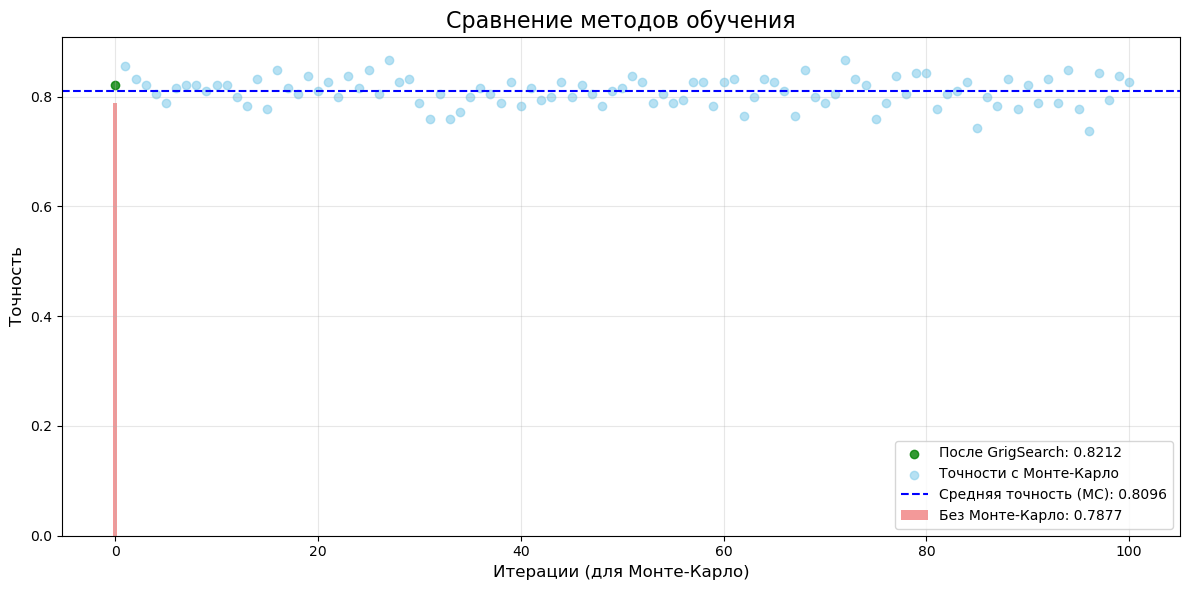

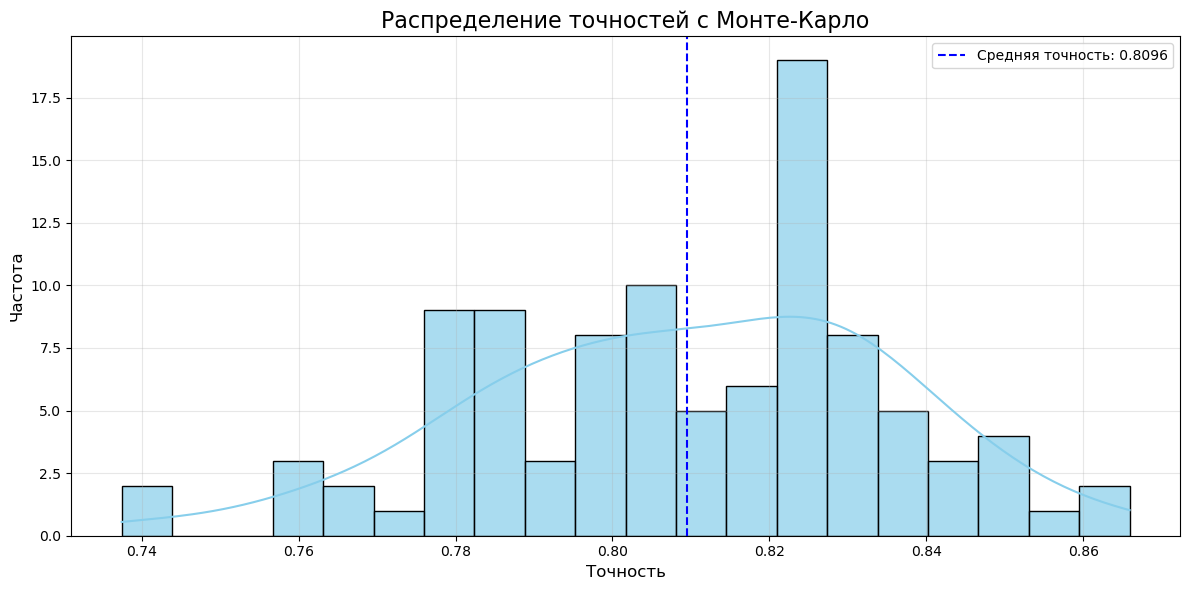

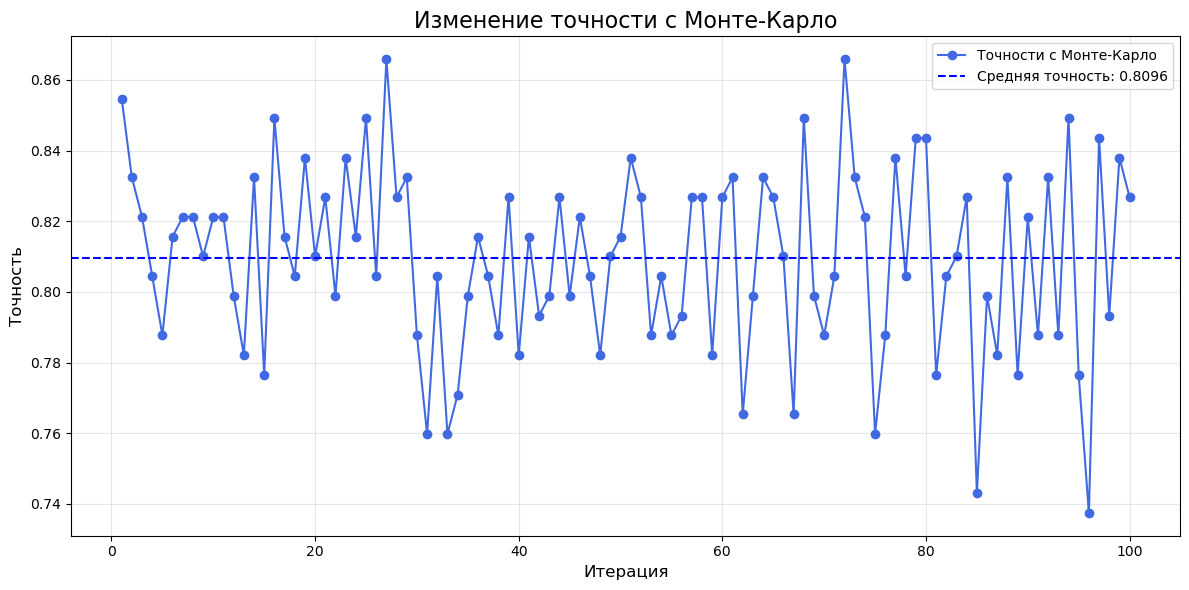

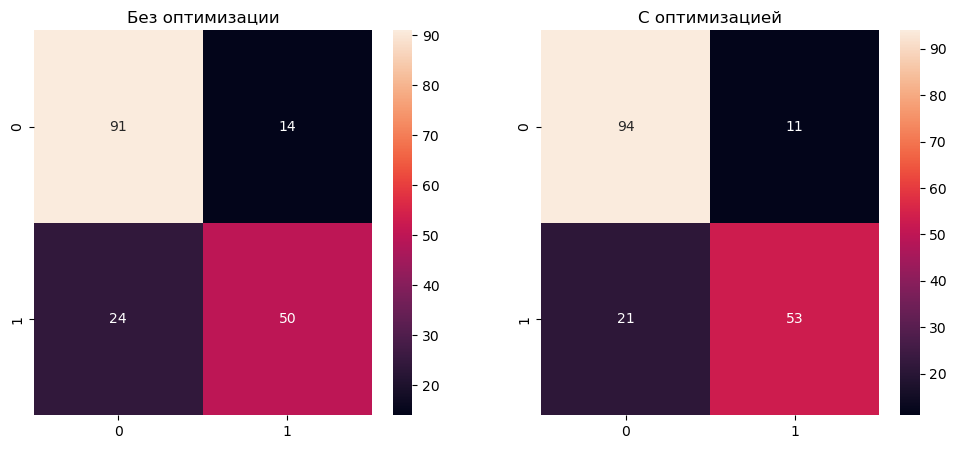

In [ ]:
# Визуализация

# График 1: Сравнение точности с и без Монте-Карло
plt.figure(figsize = (12, 6))
plt.bar(
    [0], 
    [accuracy_no_mc], 
    color = "lightcoral", 
    alpha = 0.8, 
    width = 0.4, 
    label = f"Без Монте-Карло: {accuracy_no_mc:.4f}"
)
plt.scatter(
    [0], 
    [accuracy_score(grid_predictions,y_test)], 
    color = "green", 
    alpha = 0.8,  
    label = f"После GrigSearch: {accuracy_score(grid_predictions,y_test):.4f}"
)
plt.scatter(
    range(1, n_simulations + 1), 
    accuracies_mc, 
    color = "skyblue", 
    label = "Точности с Монте-Карло", 
    alpha = 0.6
)
plt.axhline(mean_accuracy_mc, color = "blue", linestyle = "--", linewidth = 1.5, label = f"Средняя точность (MC): {mean_accuracy_mc:.4f}")
plt.title("Сравнение методов обучения", fontsize = 16)
plt.xlabel("Итерации (для Монте-Карло)", fontsize = 12)
plt.ylabel("Точность", fontsize = 12)
plt.legend(fontsize = 10)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

# График 2: Плотность распределения точностей (с Монте-Карло)
plt.figure(figsize = (12, 6))
sns.histplot(accuracies_mc, kde = True, bins = 20, color = "skyblue", alpha = 0.7)
plt.axvline(mean_accuracy_mc, color = "blue", linestyle = "--", label = f"Средняя точность: {mean_accuracy_mc:.4f}")
plt.title("Распределение точностей с Монте-Карло", fontsize = 16)
plt.xlabel("Точность", fontsize = 12)
plt.ylabel("Частота", fontsize = 12)
plt.legend(fontsize = 10)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

# График 3: Точности по итерациям
plt.figure(figsize = (12, 6))
plt.plot(range(1, n_simulations + 1), accuracies_mc, marker = "o", color = "royalblue", label = "Точности с Монте-Карло")
plt.axhline(mean_accuracy_mc, color = "blue", linestyle = "--", linewidth = 1.5, label = f"Средняя точность: {mean_accuracy_mc:.4f}")
plt.title("Изменение точности с Монте-Карло", fontsize = 16)
plt.xlabel("Итерация", fontsize = 12)
plt.ylabel("Точность", fontsize = 12)
plt.legend(fontsize = 10)
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()


cm_no_mc = confusion_matrix(y_test, model.predict(X_test))
cm_grad = confusion_matrix(y_test, best_cat.predict(X_test))

# Визуализация
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_no_mc, annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Без оптимизации')
sns.heatmap(cm_grad, annot=True, fmt='d', ax=ax[1])
ax[1].set_title('С оптимизацией')
plt.show()

# Отправим результаты на Кагл

In [ ]:
data_test = pd.read_csv("titanic_test.csv")

data_test = pd.concat([data_test,
                   pd.get_dummies(data_test["Cabin"].str.replace(r"[^A-Z]","", regex=True).str[0], prefix='Cabin').astype(int),
                   pd.get_dummies(data_test["Embarked"], prefix= "Embarked").astype(int)], axis = 1).drop(columns=["Embarked_S","Name","Ticket","Cabin","Embarked"])

data_test["Sex"] = data_test["Sex"].map({"male":1, "female":0})

In [ ]:
data_test.insert(14,"Cabin_T", 0)
data_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q
0,892,3,1,34.5,0,0,7.8292,0,0,0,0,0,0,0,0,0,1
1,893,3,0,47.0,1,0,7.0000,0,0,0,0,0,0,0,0,0,0
2,894,2,1,62.0,0,0,9.6875,0,0,0,0,0,0,0,0,0,1
3,895,3,1,27.0,0,0,8.6625,0,0,0,0,0,0,0,0,0,0
4,896,3,0,22.0,1,1,12.2875,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,NaN,0,0,8.0500,0,0,0,0,0,0,0,0,0,0
414,1306,1,0,39.0,0,0,108.9000,0,0,1,0,0,0,0,0,1,0
415,1307,3,1,38.5,0,0,7.2500,0,0,0,0,0,0,0,0,0,0
416,1308,3,1,NaN,0,0,8.0500,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_test["Survived"] = best_xgb.predict(data_test[[i for i in data_test.columns if i not in  ["Survived", "PassengerId"]]])

In [ ]:
data_test[["PassengerId","Survived"]].to_csv("xgb_results_to_kaggle.csv", index = False)